# Classification in python using scikit-learn

Much of this tutorial is based on, or inspired by, the longer fMRI-pattern-analysis course developed by Lukas Snoek at the University of Amsterdam, which you can find here: https://lukas-snoek.com/NI-edu/index.html 

We will start with simulated data, and then move on to real fMRI data. However, most of the principles apply to any source of data patterns. See Mate's sessions tomorrow for examples applied to EEG/MEG.

## Getting Ready

To give python the functionality we need, we typically have to **import** a bunch of packages (see Kshipra's session).
Many of these you will have mostly seen in previous sessions.
The important pacake for today is Scikit-learn: this is a popular and powerful library for machine learning in Python. It has a very useful website: https://scikit-learn.org/stable

In [2]:
import numpy as np              # This lets python process matrices, like Matlab
import matplotlib.pyplot as plt # This lets python plot graphs like Matlab
import seaborn as sns           # This provides another popular set of plotting functions
import pandas as pd             # To use "dataframes" (like tables in Matlab)
import os                       # To interact with the operating system, including files and paths (e.g. path.join)
import time                     # To use "time" (like "tic" in Matlab)

import nilearn as nil           # Many useful functions for MRI, including...
from nilearn import image       # to load (load_img), resample (resample_to_img), manipulate (math_img) fMRI data, etc.
from nilearn import datasets    # includes e.g. fetch_atlas_harvard_oxford
from nilearn import masking
from nilearn import maskers     # includes NiftiMasker, NiftiLabelsMasker
from nilearn import plotting    # includes plot_roi, plot_stat_map, view_img_on_surf, etc.
from nilearn import decoding    # includes Searchlight

# scikit-learn is the major library for machine learning in Python:
import sklearn as skl
from sklearn import preprocessing   # includes LabelEncoder, OneHotEncoder, StandardScaler...
from sklearn import decomposition   # includes PCA
from sklearn import model_selection # includes StratifiedKFold, LeaveOneGroupOut, etc....
from sklearn import linear_model    # includes LogisticRegression, RidgeClassifier...
from sklearn import svm             # includes SVC, NuSVC & LinearSCV...
from sklearn import discriminant_analysis # includes LinearDiscriminantAnalysis
from sklearn import metrics         # includes accuray, balanced accuracy, roc_auc_score, etc....
from sklearn import pipeline        # includes make_pipeline
from sklearn import inspection      # includes DecisionBoundaryDisplay

# scipy? # provides basic statistic functions, e.g. t-tests, and allows import of Matlab files
# glob? # to search filenames with wildcards

%matplotlib inline

\
First, we'll **set the seed to numpy's random number generator**, to get the same sequence of random values every time:

In [3]:
np.random.seed(3) # (if it's not desireable to set a global seed, a seeded RandomState can be passed to the relevant functions)


## Examples using simulated data, with a true effect

### Define data matrix and labels:

Now, we'll **simulate some data from a single participant**.
Let's define **two conditions**, which could be e.g. button presses using two different fingers.
We'll simulate **four runs**, with **three repeats** of each condition per run. We'll assume that each repeat has been separately estimated from a GLM (see Rik's & Dace's sessions), so we would have 4 x 3 x 2 = 24 activation patterns. In an fMRI experiment these might be whole-brain volumes; in E/MEG these might be activations across electrodes. The values in each pattern could be beta coefficients, contrasts, or t statistics.
For now, **we'll just consider two voxels** from each activation map, to make things easier to visualise.

In [5]:
nruns = 4     # number of runs 
n_per_run = 3 # number of repetitions per run
mu1 = np.array([2.0, -0.5]) # mean activation for condition 1 (1st voxel activated; 2nd voxel deactivated)
mu2 = np.array([-0.5, 2.0]) # mean activation for condition 2 (opposite pattern)
voxel_covariance = np.diag([0.0, 3.0])+1 # independent noise per voxel; 2nd voxel is noisier; shared noise is positively correlated
# print("Noise covariance matrix: \n", voxel_covariance )

data_per_run = []   # list of pattern matrices (one per run)
labels_per_run = [] # list of label vectors (one per run)
for r in np.arange(nruns):  # loop over runs
    a1 = np.random.multivariate_normal(mu1, voxel_covariance, size=n_per_run) # activations for condition 1
    a2 = np.random.multivariate_normal(mu2, voxel_covariance, size=n_per_run) # activations for condition 2 (different mean, same noise covarience)
    data_matrix = np.concatenate((a1, a2), axis=0) # stack condition 1 (n rows of observations) then condition 2 (n more observations)
    # add some extra noise that is similar across conditions and voxels, but whose mean and variance increases across runs:
    data_matrix = data_matrix + np.random.normal( r*10, r, size=(2*n_per_run,2))
    
    label_vector = n_per_run*["Thumb"] + n_per_run*["Pinky"] # give each pattern a label that indicates from which condition it was drawn
    
    data_per_run.append( data_matrix )  # append this run's data to list
    labels_per_run.append( label_vector ) 
    
print("\nData matrix for one run:\n", data_per_run[0])
print("\nLabel vector for one run:\n", labels_per_run[0])


Data matrix for one run:
 [[ 1.72455107  1.0551566 ]
 [ 3.54427659 -1.61820838]
 [ 1.49177829  1.54872367]
 [-0.0968118   1.70510126]
 [ 0.36050896  4.41277063]
 [-1.40275063  1.12339592]]

Label vector for one run:
 ['Thumb', 'Thumb', 'Thumb', 'Pinky', 'Pinky', 'Pinky']


\
We now have everything we need for a decoding analysis. However, functions often require data to be represented numerically, so we will also **convert the labels to integers**. This can be done in various ways, but here we'll use the the `LabelEncoder` class from scikit-learn:

In [6]:
lab_enc = skl.preprocessing.LabelEncoder() # this initialises the LabelEncoder object
labels_per_run_int = []
for r in np.arange(nruns):
    labels_per_run_int.append( lab_enc.fit_transform(labels_per_run[r]) )
    
print("Integer labels for all runs:\n", labels_per_run_int)

Integer labels for all runs:
 [array([1, 1, 1, 0, 0, 0]), array([1, 1, 1, 0, 0, 0]), array([1, 1, 1, 0, 0, 0]), array([1, 1, 1, 0, 0, 0])]


\
Notice that we first initialised a `LableEncoder` object, and then called its `.fit_transform` method. Many objects also have `.fit` and `.transform` methods that can be called separately. This procedure is similar for most objects in scikit-learn.

Before doing anything else, let's **plot the data:**

In [7]:
concatenated_runs  = np.concatenate(data_per_run,axis=0)       # concatenate data across runs
concatenated_labels= np.concatenate(labels_per_run_int,axis=0) # concatenate labels across runs

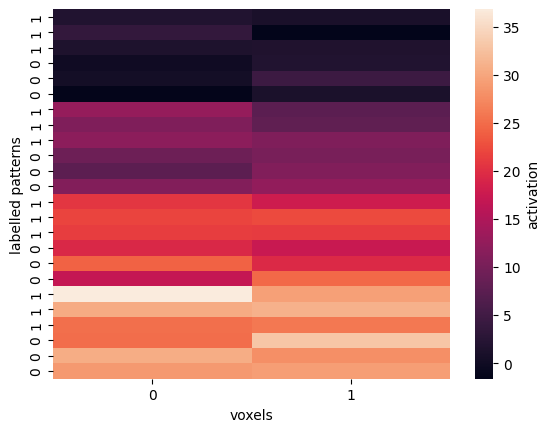

In [11]:
ax = sns.heatmap(concatenated_runs, yticklabels=concatenated_labels);
ax.set( xlabel = "voxels" )
ax.set( ylabel = "labelled patterns" )
ax.collections[0].colorbar.set_label("activation")

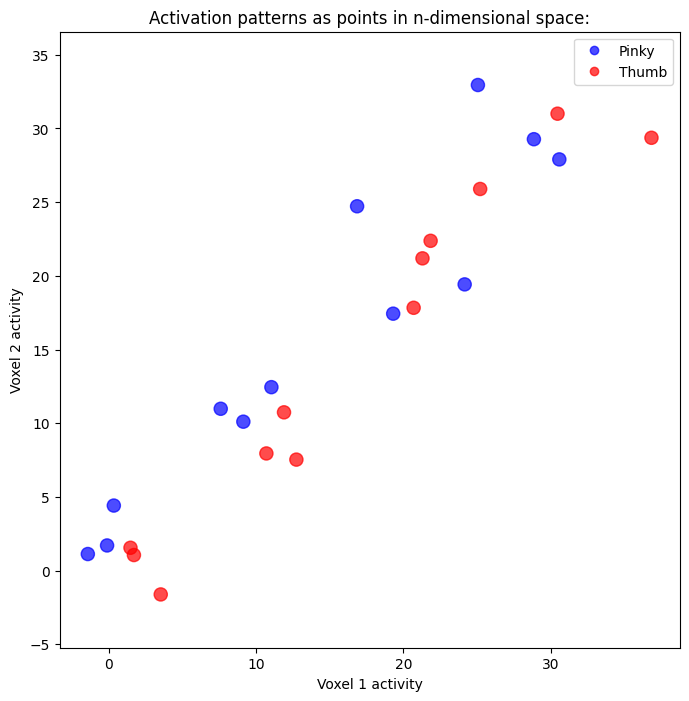

In [12]:
fig=plt.figure(figsize=(8,8));  # create a matplotlib figure
plt.title('Activation patterns as points in n-dimensional space:');
scatter = plt.scatter(concatenated_runs[:,[0]], concatenated_runs[:,[1]], 
                      s= 90, alpha=0.7, c=concatenated_labels, cmap='bwr');
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels_per_run[0])); # "set" returns unique values
plt.xlabel('Voxel 1 activity');
plt.ylabel('Voxel 2 activity');
plt.rcParams.update({'font.size': 18});
plt.axis('equal');


### Initial classification, without cross-validation:

At this stage, it is common to **standardise each feature**, e.g. by rescaling into the range [0 1], or by z-scoring (subtracting the mean and dividing by the standard deviation across samples). For many classifiers, standardizing each feature across all samples should not change the classification accuracy. (Imagine how these transformations change the distribution of the data in the figure above.) However, putting each feature on the scame scale can help parameters to be estimated efficiently, and may be necessary for some models to converge. 

Consider whether it would it be a good or bad idea to rescale features for each class separately? 

Would it be a good or bad idea to rescale features for each run separately?

For now, let's z-score each feature across all samples of all runs. Again, we can do this by initialising a scikit-learn object and calling its `fit_transform` method:

In [13]:
scaler           = skl.preprocessing.StandardScaler()
concatenated_runs= scaler.fit_transform(concatenated_runs)

Let's plot the data again to confirm:

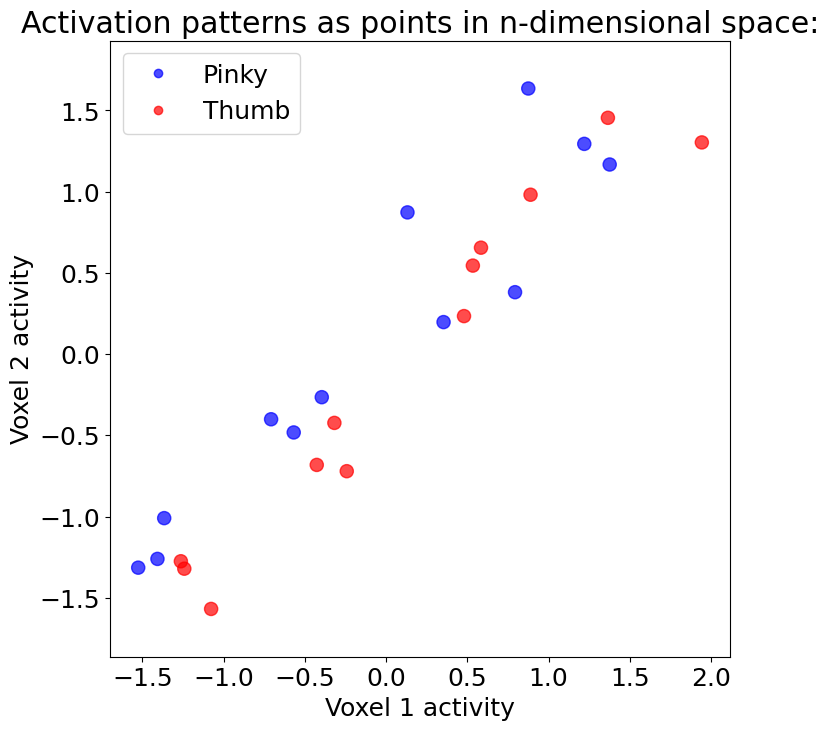

In [14]:
fig=plt.figure(figsize=(8,8));  # create a matplotlib figure
plt.title('Activation patterns as points in n-dimensional space:');
scatter = plt.scatter(concatenated_runs[:,[0]], concatenated_runs[:,[1]], 
                      s= 90, alpha=0.7, c=concatenated_labels, cmap='bwr');
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels_per_run[0])); # "set" returns unique values
plt.xlabel('Voxel 1 activity');
plt.ylabel('Voxel 2 activity');
plt.rcParams.update({'font.size': 18});
plt.axis('equal');

\
Now we can proceed to classification. We'll start with a logistic regression classifier, which we'll initialise to a variable called `LR`.

Each **classifier needs to be "trained" or "fit" using "training data" and corresponding labels.** This uses the training data to optimise the parameters of the model, to best match the labels to some function (often a linear combination) of the features.

In scikit-learn, this uses the `.fit` method of the classifier, which needs to be given the patterns matrix and labels as inputs. To start with, we'll train the classfier using all the data, concatenated across runs:

In [15]:
LR = skl.linear_model.LogisticRegression(solver='lbfgs') # there are more options that could be set here; we won't worry about them
LR.fit(concatenated_runs, concatenated_labels)

LogisticRegression()

The **estimated (fitted) coefficients are now stored in the classifier object**. Notice that for this linear classifier we have one coefficient per feature (voxel):

In [16]:
print("Coefficients:\n", LR.coef_)

Coefficients:
 [[ 0.77968213 -0.74745793]]


\
These coefficients define the linear decision boundary, so we can now plot this:

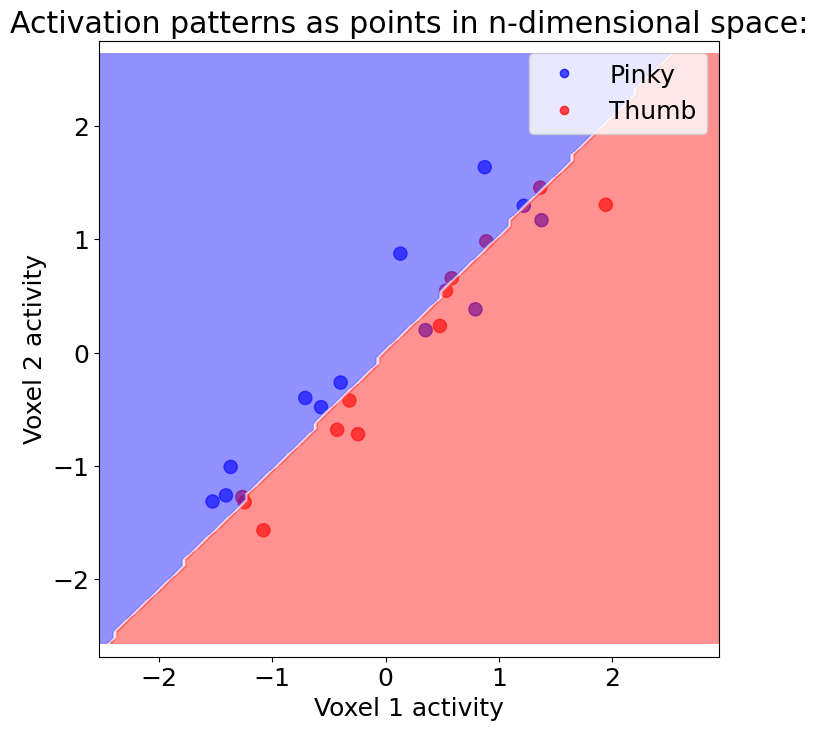

In [17]:
skl.inspection.DecisionBoundaryDisplay.from_estimator(LR, concatenated_runs, alpha=0.5, ax=fig.axes[0], cmap='bwr', response_method='predict');
fig

\
The next step is to **"test" the model, by giving it some patterns and "predicting" their labels**. For now, we'll give it the same data we used to train the model. (Some of you may have a question at this point - if so, hold that thought...) 

In [13]:
predicted_labels = LR.predict(concatenated_runs)
print("Predictions for all samples:\n", predicted_labels)

Predictions for all samples:
 [1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0]


\
How accurate are these predictions? We can **"evaluate" the predictions by comparing them with the true values. The quality of the predictions is summarised as a "performance", "score" or "metric"**. If we had continuous predictions (a regression model), we might correlate them with the true values. Here we have categorical predictions (a classification model), which we can compare with the true values in various ways...

The **simplest score, called "accuracy," is just the proportion of all predictions that are correct**. What is the best possible accuracy? What is the worst possible accuracy? What accuracy would we expect by chance?

Calculating accuracy is easy:

In [14]:
print(np.mean(concatenated_labels==predicted_labels))

0.8333333333333334


\
Scikit-learn also has a function to do this:

In [15]:
accuracy = skl.metrics.accuracy_score(concatenated_labels, predicted_labels)
print(accuracy)

0.8333333333333334


\
Actually scikit-learn has **many metrics to choose from.** The only thing to recommend accuracy as a metric is its simplicity. Otherwise, it is relatively insensitive (because binary guesses discard information about the confidence of a particular prediction) and can be misleading if classes are unbalanced (more about that later).

A metric that incorporates the confidence of each prediction, and can handle unbalanced classes, but is rather complicated, is the "**Area Under the Receiver Operating Characteristic curve**" (AUROC, or just AUC). We can use a function from scikit-learn to calculate this, but instead of vectors of true and predicted labels, it generally needs matrices of true and predicted probabilities per class. (In this binary case, we could give it the vector labels and the probabilities for the class with the largest label, but this syntax doesn't generalise to more than two classes).

Matrices of true class probabilities can be constructed from the true labels using scikit-learn's `one-hot encoder` function:


In [16]:
ohe = skl.preprocessing.OneHotEncoder(sparse_output=False)  # we don't want a "sparse" output
true_probabilities = ohe.fit_transform(concatenated_labels.reshape(-1,1)) # the reshape is needed because the function expects a 2D input
print("True probabilities per class, for first 5 patterns:\n", true_probabilities[0:5])

True probabilities per class, for first 5 patterns:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


\
Matrices of predicted class probabilities can be returned by many classifier objects, including logistic regression:

In [17]:
predicted_probabilities = LR.predict_proba(concatenated_runs)
print("Predicted probabilities per class, for first 5 patterns:\n", predicted_probabilities[0:5])

Predicted probabilities per class, for first 5 patterns:
 [[0.49885482 0.50114518]
 [0.50751113 0.49248887]
 [0.46147032 0.53852968]
 [0.58321849 0.41678151]
 [0.58077977 0.41922023]]


\
With these, we can now calculate the AUROC:

In [18]:
AUROC = skl.metrics.roc_auc_score(true_probabilities, predicted_probabilities)
print("AUROC:")
print(AUROC)
AUROC = skl.metrics.roc_auc_score(concatenated_labels, predicted_probabilities[:,1]) # alternative syntax for binary classifcation
print(AUROC)

AUROC:
0.9027777777777777
0.9027777777777777


\
Notice that the performance is a bit better than simple accuracy. (Both metrics are bounded between 0 and 1. For AUROC, chance is 0.5. For balanced binary classification, as here, chance accuracy is also 0.5.)

So far, so good. BUT... **these results are biased and cannot be trusted, because we tested the model on the same data that we used for training!** This is like taking an exam after having already seen the correct answers. To emphasise the problem, let's create a **new simulated dataset**, with the same trial structure, but a more realistic number of features/voxels (e.g. 30), and **with no true difference between the conditions** (both are drawn at random fom the same distribution):


## Examples using simulated data with NO true effect - the importance of cross-validation

In [19]:
nvox = 30                          # number of voxels
mu = np.arange(nvox)               # mean activation per voxel (voxels all have different activation strength) for both conditions 1 & 2
voxel_covariance = np.diag(mu) + 1 # independent noise per voxel is proportional to mean, plus some covariance

null_data_per_run = []             # list of pattern matrices (one for each run)
for r in np.arange(nruns):
    data_matrix =  np.random.multivariate_normal(mu, voxel_covariance, size= 2 * n_per_run) # activations are drawn from THE SAME DISTRIBUTION FOR BOTH CONDITIONS!
    null_data_per_run.append( data_matrix ) 

null_concatenated_runs = np.concatenate(null_data_per_run,axis=0)             # concatenate runs
null_concatenated_runs = scaler.fit_transform(null_concatenated_runs)         # scale data per voxel
LR.fit(null_concatenated_runs, concatenated_labels)                           # fit the classifier       
null_predicted_labels = LR.predict(null_concatenated_runs)                    # predict the labels
accuracy = skl.metrics.accuracy_score(concatenated_labels, null_predicted_labels) # measure accuracy
print('True labels:\n', concatenated_labels)
print('Predicted labels from null data:\n', null_predicted_labels)
print('Accuracy from null data:', accuracy)

True labels:
 [1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0]
Predicted labels from null data:
 [1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0]
Accuracy from null data: 1.0


\
Here we have got perfect classification, despite both conditions being random samples from the same distribution! 

Let's just **try using a different classifier**, to show that this is a general problem. Another popular classifier is a **Support Vector Machine**. The procedure is essentially the same:
 - create the classifier object
 - train (fit) the classifier (using (scaled) patterns and their labels)
 - test the classifier (predict labels from patterns)
 - calculate a performance measure

In [20]:
SVM=skl.svm.LinearSVC(dual=True)
SVM.fit(null_concatenated_runs, concatenated_labels)
null_predicted_labels = SVM.predict(null_concatenated_runs)
accuracy = skl.metrics.accuracy_score(concatenated_labels, null_predicted_labels)
print('Accuracy from null data:', accuracy)

Accuracy from null data: 1.0


\
With more voxels than conditions (which is common in neuroimaging), the classifier can easily separate conditions based on noise (chance differences). This is called **overfitting**. **When testing on the same data that was for training**, these chance differences are the same, so the **classification performance is positively biased**. 

We solve this using **cross-validation**.

Cross-validation means that the classifier is **tested on separate data**, that was not used for training. Independent data will have different noise. Therefore, overfitting based on noise in the training samples will still occur, but will not generalise to the testing samples, and classifier performance will be **unbiased**.

There are different ways to split data into test and train sets. The simplest case is a **single partition, called a "hold-out"** scheme. Here we'll split the data into odd and even runs:

In [21]:
null_concatenated_runs_train_odd = np.concatenate(null_data_per_run[0::2],axis=0) # concatenate training data across odd runs
null_concatenated_runs_test_even = np.concatenate(null_data_per_run[1::2],axis=0) # concatenate testing data across even runs

concatenated_labels_train_odd = np.concatenate(labels_per_run_int[0::2],axis=0) # concatenate training labels across odd runs
concatenated_labels_test_even = np.concatenate(labels_per_run_int[1::2],axis=0) # concatenate testing labels across even runs

\
Now we can standardise the training data and use these to train the classifier:

In [22]:
LR.fit(scaler.fit_transform(null_concatenated_runs_train_odd), concatenated_labels_train_odd)

LogisticRegression()

Now when we test the classifier on the independent training data, the accuracy should close be to chance (with some random error):

In [23]:
null_predicted_labels_test_even = LR.predict(scaler.transform(null_concatenated_runs_test_even))
accuracy = skl.metrics.accuracy_score(concatenated_labels_test_even, null_predicted_labels_test_even)
print('True labels (from even runs):\n', concatenated_labels_test_even)
print('Predicted labels from null data (even runs):\n', null_predicted_labels_test_even)
print('Accuracy from null data (even runs):', accuracy)

True labels (from even runs):
 [1 1 1 0 0 0 1 1 1 0 0 0]
Predicted labels from null data (even runs):
 [1 1 0 1 1 1 1 1 1 1 0 1]
Accuracy from null data (even runs): 0.5


\
(Notice here that we used  `scaler.transform`  rather than  `scaler.fit_transform`. This means that  we use the use the standardisation parameters fit using the train data for standardising the test data. One could instead independently standardise the test set, or standardise the whole dataset before partitioning. Opinions differ on whether it matters, and which, if any, is best.)

Okay, accuracy is now close to chance, as it should be. But notice that the classifier is now:
- trained on only some (here, half) of the data, which makes it less sensitive
- tested on only some (here, half) of the data, which makes its performance more variable (less reliable)

For more efficient use of the data, we can use **K-fold cross-validation**. This means that the data are split into K parts, and in each of K folds/splits one part is used for testing and the rest are used for training. This way, each fold uses more training data (so more sensitive), and after combining predictions across folds there are more predictions (so a more reliable accuracy estimate). Generally we want the proportion of classes to be as balanced as possible in each fold (and therefore in the training set). To do this we could use scikit-learn's `StratifiedKFold` object:

In [24]:

skf = skl.model_selection.StratifiedKFold(n_splits=3) # create the object
folds = tuple(skf.split(null_concatenated_runs, concatenated_labels)) # create the folds
# note: the folds are returned as a "generator", which means that each element can only be accessed once and then disappears; the conversion to a tuple makes them persist.

for i, fold in enumerate(folds):

    # fold  is a tuple, which contains indices to train and test samples
    train_idx, test_idx = fold # unpack the tuple
    
    print("Fold %i" % (i + 1))
    print("Train samples:", train_idx)
    print("Test samples:", test_idx, "\n")
    

Fold 1
Train samples: [ 7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test samples: [0 1 2 3 4 5 6 9] 

Fold 2
Train samples: [ 0  1  2  3  4  5  6  9 14 17 18 19 20 21 22 23]
Test samples: [ 7  8 10 11 12 13 15 16] 

Fold 3
Train samples: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16]
Test samples: [14 17 18 19 20 21 22 23] 



\
Note two things here. 

Firstly, this is only one of many ways to split our 24 samples into three parts. We could repeat the partitioning with different random splits, using `.RepeatedStratifiedKFold`. This would further increase the total number of predictions, and therefore the precision of the estimated accuracy. However, it would also take longer. Also, note that the total number of unique ways to split into K parts decreases as K increases. Therefore, the **choice of K involves a trade-off between senstivity and precision**.

Secondly, here samples from more than one run are spread across folds. For fMRI, this is NOT what we want, because **for fMRI samples within a run are likely not independent**, and thus the train/test splits will also not be independent. Instead, the best and typical approach is to cross-validate across runs. To do this, we can use the **`LeaveOneGroupOut`** object (see also `GroupKFold`, and `LeavePGroupsOut`), and tell it that we want to treat each fMRI run as a group:

In [25]:

run_indices =  np.concatenate([[i] * 2 * n_per_run for i in range(nruns)]) # get the indices of each run
print("Run indices:",run_indices,"\n")

logo = skl.model_selection.LeaveOneGroupOut()
folds = tuple(logo.split(null_concatenated_runs, concatenated_labels, run_indices))

for i, fold in enumerate(folds):
    train_idx, test_idx = fold
    print("Fold ", i, " test samples:", test_idx)

Run indices: [0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3] 

Fold  0  test samples: [0 1 2 3 4 5]
Fold  1  test samples: [ 6  7  8  9 10 11]
Fold  2  test samples: [12 13 14 15 16 17]
Fold  3  test samples: [18 19 20 21 22 23]


\
It can be cumbersome to specify every step within a loop across the folds (e.g. scaling the data, training the classifier, testing the classifier, plus any extra steps). This can increase the risk of accidentally using test data when pre-processing or training the classifier, or accidentally applying different pre-processing to train and test sets.

Scikit-learn has a mechanism called **"pipelines"** to make this more efficient, and reduce the risk of such errors. To make a pipeline, we call the `make_pipeline` function, and give it the objects for each step of the analysis:

In [26]:
pipe = skl.pipeline.make_pipeline(scaler, SVM)
print(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual=True))])


\
Then, in the cross-validation loop, we can just call the pipeline's `.fit` method on the training data and its `.predict` method on the test data, to automatically apply all these steps:

In [27]:
accuracy = np.full(nruns,np.nan)
for i, fold in enumerate(folds):
    train_idx, test_idx = fold # get the train and test indices
    pipe.fit(null_concatenated_runs[train_idx,:],concatenated_labels[train_idx]) # do all preprocessing and model fitting on training data
    null_predicted_labels = pipe.predict(null_concatenated_runs[test_idx,:])     # do prediction on test data
    accuracy[i] = skl.metrics.accuracy_score(concatenated_labels[test_idx], null_predicted_labels) # score the predictions
print("Accuracy per fold:", accuracy)
print("Mean accuracy for random data:", np.mean(accuracy))

Accuracy per fold: [0.5        0.66666667 0.33333333 0.66666667]
Mean accuracy for random data: 0.5416666666666666


\
To make things *even easier*, we can pass the pipeline, cross-validation scheme, and performance metric to a single function, to do everything in one go: 

In [28]:
accuracy = skl.model_selection.cross_val_score(pipe, null_concatenated_runs, concatenated_labels,
                                    groups  = run_indices,
                                    scoring = 'accuracy',
                                    cv      = logo)
print("Crossvalidated accuracy per fold for random data:", accuracy)                   
                                    

Crossvalidated accuracy per fold for random data: [0.5        0.66666667 0.33333333 0.66666667]


The returned accuraccies per fold should be the same as above.

.

### Final example using simulated data:  true effect with cross-validation:
Now that we have a nice cross-validated pipeline, let's return to the original simulated data that *does* have a difference between conditions, and check that the decoding accuracy is well above chance:

In [29]:
accuracy = skl.model_selection.cross_val_score(pipe, concatenated_runs, concatenated_labels,
                                    groups  = run_indices,
                                    scoring = 'accuracy',
                                    cv      = logo)
print("Crossvalidated accuracy per fold for original data:", accuracy)  
print("Mean crossvalidated accuracy for original data:    ", np.mean(accuracy))

Crossvalidated accuracy per fold for original data: [0.83333333 0.83333333 0.83333333 0.66666667]
Mean crossvalidated accuracy for original data:     0.7916666666666666


## Examples using real brain data

Okay, time to use some real brain data! 

We'll use the 3T dataset from the fMRI-pattern-analysis course developed by Lukas Snoek at the University of Amsterdam: https://lukas-snoek.com/NI-edu/index.html. This uses stimuli from the publicly available "Face Research Lab London Set" (https://figshare.com/articles/dataset/Face_Research_Lab_London_Set/5047666). Participants were shown 480 images of faces for 1.25 seconds each, separated by 3.75 seconds. Faces counterbalanced sex (male, female) and ethnicity (Caucasian, East-Asian, Black) across 40 identities. Each identity was shown six times with a neutral expression, and six times smiling. Stimuli were divided into 12 runs, across two days, with 40 stimuli per run. 1 in 8 faces were followed by a judgement of attractiveness, dominance or trustworthiness. Functional scans were acquired at a TR of 0.7 s and an isotropic resolution of 2.7 mm. Response patterns, in MNI space, were estimated for individual trials.

These activation patterns have already been downloaded. Let's look at the data from one session of one participant:


In [30]:
# Get directory with data:
#data_dir="/group/duncan-lab/users/dm01/COGNESTIC24/NI-edu-data-minimal-djm";
data_dir="NI-edu-data-minimal-djm";
pattern_dir = os.path.join(data_dir, 'derivatives', 'pattern_estimation', 'sub-03', 'ses-1', 'patterns')

# Check what's in it:
print('\n'.join(sorted(os.listdir(pattern_dir))))

sub-03_ses-1_task-face_run-1_events.tsv
sub-03_ses-1_task-face_run-1_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz
sub-03_ses-1_task-face_run-2_events.tsv
sub-03_ses-1_task-face_run-2_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz
sub-03_ses-1_task-face_run-3_events.tsv
sub-03_ses-1_task-face_run-3_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz
sub-03_ses-1_task-face_run-4_events.tsv
sub-03_ses-1_task-face_run-4_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz
sub-03_ses-1_task-face_run-5_events.tsv
sub-03_ses-1_task-face_run-5_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz
sub-03_ses-1_task-face_run-6_events.tsv
sub-03_ses-1_task-face_run-6_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz


For each of six runs, there is a .tsv file that contains the definition of each trial in the run, plus a 4D nifti file ending in "_beta.nii.gz", which conatins the activation patterns we will use.
First, from the events file of run 1, we'll **extract class labels** that indicate whether each face was "smiling" or "neutral":

In [31]:
# Load events-file corresponding to run 1
events_file = os.path.join(pattern_dir, 'sub-03_ses-1_task-face_run-1_events.tsv') 
events = pd.read_csv(events_file, sep='\t') # read into pandas dataframe
pd.options.display.width=250
print(events.head(15))

# Filter out 'response' and 'rating' events
events = events.loc[events['trial_type'].str.contains('STIM'), :]

# Encode the string labels into integers
labels = lab_enc.fit_transform(events['expression']) # Encode the "expression" column (containing either "smiling" or "neutral") as integers
print('Labels:\n', labels)  # smiling = 1, neutral = 0

        onset  duration        trial_type expression  face_id  face_age face_sex    face_eth  average_attractiveness  catch  rating_score response_hand  subject_attractiveness  subject_dominance  subject_trustworthiness
0    6.022445  1.233307  00STIM117smiling    smiling    117.0      26.0     male       white               -0.485729    0.0           NaN           NaN                  0.9900             1.1850                   1.3625
1   11.022318  1.233310  01STIM027smiling    smiling     27.0      26.0   female       white                1.772827    0.0           NaN           NaN                  0.1325             0.6525                   1.1575
2   16.022165  1.233322  02STIM027neutral    neutral     27.0      26.0   female       white                1.772827    0.0           NaN           NaN                  0.1325             0.6525                   1.1575
3   21.022053  1.233282  03STIM092smiling    smiling     92.0      32.0     male       white               -0.932899    

\
Now let's **load the fMRI data** from run 1:

In [32]:
betas_path = os.path.join(pattern_dir, 'sub-03_ses-1_task-face_run-1_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz')
patterns_4D = nil.image.load_img(betas_path)

print(f"Shape of betas: {patterns_4D.shape}")

Shape of betas: (73, 86, 66, 40)


\
The first three dimensions are the x, y, and z coordinates.
The 4th dimension is trials. We can again see that there were 40 trials (faces) presented in this run. 

We don't expect all of these voxels to contain signal (some are not even in the brain!). So we will **select voxels from a Region Of Interest (ROI).** This is a type of **feature selection**, which restricts the analysis to brain regions we are interested in, and/or brain regions where we expect to find signal. To avoid biasing the results, any data used for feature selection must be independent of the data being classified. Since these data are in MNI space, we can use any mask independently defined in MNI space. Here, we'll use Nilearn to load anatomical ROIs from the Harvard-Oxford subcortical atlas. These are returned as a dictionary that stores the `filename`, `description` and, importantly, `labels` (ROI names) and `maps` (a 3D volume of integers that index the ROI names):


File name of atlas: NI-edu-data-minimal-djm/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-2mm.nii.gz

ROI names:
 ['Background', 'Left Cerebral White Matter', 'Left Cerebral Cortex ', 'Left Lateral Ventrical', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter', 'Right Cerebral Cortex ', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens']

Shape of ROI map:
 (91, 109, 91)


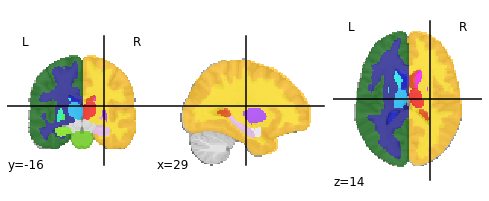

In [33]:
# this is a subcortical, maximum-probability, anatomical atlas, thresholded at 25%, with 2 mm resolution
HO_atlas = nil.datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm',data_dir) 
print("File name of atlas:", HO_atlas['filename'])
# print(HO_atlas['description'])
print("\nROI names:\n", HO_atlas['labels'])
# print("ROI mask:\n", HO_atlas['maps'])
print("\nShape of ROI map:\n", HO_atlas['maps'].shape)
nil.plotting.plot_roi(HO_atlas['filename']);

We can see that, although the functional data and the ROI masks are both in MNI space, they have different dimensions. We can use nilearn to **resample** the ROIs to match the data:

In [34]:
resampled_ROI_map = nil.image.resample_to_img(HO_atlas['maps'], patterns_4D, interpolation='nearest')
# note that for continuous-valued data we would want continuous interpolation, but here nearest-neighboour interpolation preserves the integer ROI values 
print("Shape of resampled ROI map:", resampled_ROI_map.shape)

Shape of resampled ROI map: (73, 86, 66)


\
Now we'll select the amygdalae, and use nilearn's `math_img` function to turn them into a binary mask. It's sensible to plot this, to check that it looks correct:

Indices of left and right amygdala: 10 20


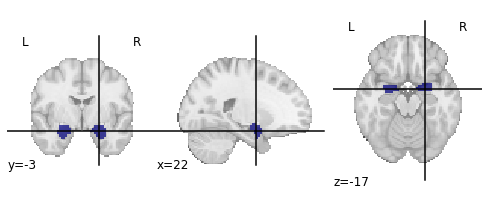

In [35]:

l_amyg_id = HO_atlas['labels'].index('Left Amygdala')
r_amyg_id = HO_atlas['labels'].index('Right Amygdala')
print("Indices of left and right amygdala:", l_amyg_id, r_amyg_id)

amyg_ROI = nil.image.math_img(f'(map == {l_amyg_id}) | (map == {r_amyg_id})', map=resampled_ROI_map)
nil.plotting.plot_roi(amyg_ROI);

Now we can pass this ROI to a `masker` object, and apply it to the activation patterns:

Shape of pattern matrix from chosen ROI: (40, 248)


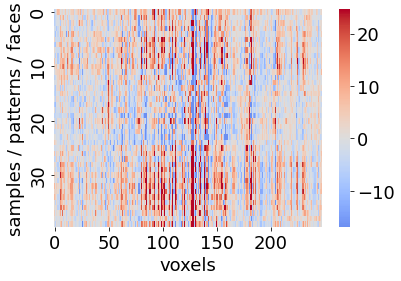

In [36]:
masker = nil.input_data.NiftiMasker(amyg_ROI)
patterns_ROI = masker.fit_transform(patterns_4D) 
# (if we hadn't resampled the ROI, the masker could also do this; we would provide "target_affine" as the space of the data)

print('Shape of pattern matrix from chosen ROI:', patterns_ROI.shape)

ax = sns.heatmap(patterns_ROI, cmap='coolwarm', center=0, robust=1, xticklabels=50, yticklabels=10)
ax.set(xlabel="voxels", ylabel="samples / patterns / faces");

\
We can see that some of these voxels are correlated, and some will be noisier than others. Classifiers are often able to handle this, but we may choose to apply **dimension reduction**. This is sometimes called **feature extraction**, and a common method is principle component analysis (**PCA**):

Shape of pattern matrix after PCA: (40, 10)


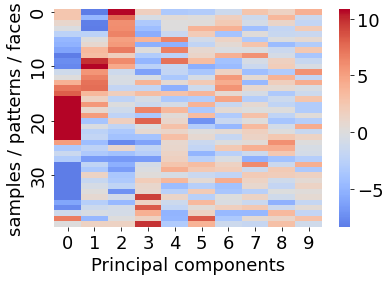

In [37]:
patterns_ROI = scaler.fit_transform (patterns_ROI)

pca = skl.decomposition.PCA(n_components=10)
pca.fit(patterns_ROI)
patterns_ROI_PCA10 = pca.transform(patterns_ROI)

print("Shape of pattern matrix after PCA:", patterns_ROI_PCA10.shape)

ax = sns.heatmap(patterns_ROI_PCA10, cmap='coolwarm', center=0, robust=1, xticklabels=1, yticklabels=10)
ax.set(xlabel="Principal components", ylabel="samples / patterns / faces");

Note that features are typically standardized before PCA, otherwise the principal components will be dominated by features with larger scales. However, standardization means that features that originally had low variance will be upweighted, under the assumption that all features are expected to be equally predictive. In fMRI, noisy/non-predictive features may have low variance, so upweighting them may be detrimental to performance.

\
Now let's put everything together: load data from all six runs of this day...

In [38]:
ROI_data_per_run   = [] # list of ROI's pattern matrices (one for each run)
brain_data_per_run = [] # also save the whole brain data for running a searchlight later
labels_per_run     = [] # list of label vectors (one for each run)
for day in [1]:
    pattern_dir = os.path.join(data_dir, 'derivatives', 'pattern_estimation', 'sub-03', f'ses-{day}', 'patterns')

    for run in (np.arange(6)+1):
        betas_file = os.path.join(pattern_dir, f'sub-03_ses-{day}_task-face_run-{run}_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz')
        print(betas_file)
        patterns_4D = nil.image.load_img(betas_file) 

        patterns_4D = nil.image.clean_img(patterns_4D, standardize=True, detrend=False)
        
        patterns_ROI = masker.fit_transform(patterns_4D) 

        events_file = os.path.join(pattern_dir, f'sub-03_ses-{day}_task-face_run-{run}_events.tsv')
        events = pd.read_csv(events_file, sep='\t') # read into pandas dataframe
        events = events.loc[events['trial_type'].str.contains('STIM'), :] # Filter out 'response' and 'rating' events
        label_vector = lab_enc.fit_transform(events['expression']) # Encode the "expression" column (containing either "smiling" or "neutral") as integers

        # patterns_ROI = scaler.fit_transform (patterns_ROI)
        
        ROI_data_per_run.append( patterns_ROI )  # append this run's data to list
        brain_data_per_run.append( patterns_4D )
        labels_per_run.append( label_vector ) 


NI-edu-data-minimal-djm/derivatives/pattern_estimation/sub-03/ses-1/patterns/sub-03_ses-1_task-face_run-1_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz


/home/dm01/.conda/envs/cognestic23/lib/python3.11/site-packages/nilearn/image/image.py:1271: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  data = signal.clean(


NI-edu-data-minimal-djm/derivatives/pattern_estimation/sub-03/ses-1/patterns/sub-03_ses-1_task-face_run-2_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz


/home/dm01/.conda/envs/cognestic23/lib/python3.11/site-packages/nilearn/image/image.py:1271: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  data = signal.clean(


NI-edu-data-minimal-djm/derivatives/pattern_estimation/sub-03/ses-1/patterns/sub-03_ses-1_task-face_run-3_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz


/home/dm01/.conda/envs/cognestic23/lib/python3.11/site-packages/nilearn/image/image.py:1271: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  data = signal.clean(


NI-edu-data-minimal-djm/derivatives/pattern_estimation/sub-03/ses-1/patterns/sub-03_ses-1_task-face_run-4_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz


/home/dm01/.conda/envs/cognestic23/lib/python3.11/site-packages/nilearn/image/image.py:1271: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  data = signal.clean(


NI-edu-data-minimal-djm/derivatives/pattern_estimation/sub-03/ses-1/patterns/sub-03_ses-1_task-face_run-5_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz


/home/dm01/.conda/envs/cognestic23/lib/python3.11/site-packages/nilearn/image/image.py:1271: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  data = signal.clean(


NI-edu-data-minimal-djm/derivatives/pattern_estimation/sub-03/ses-1/patterns/sub-03_ses-1_task-face_run-6_space-MNI152NLin2009cAsym_desc-trial_beta.nii.gz


/home/dm01/.conda/envs/cognestic23/lib/python3.11/site-packages/nilearn/image/image.py:1271: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  data = signal.clean(


\
...and try to decode expression within the amygdala ROI, using leave-one-run-out cross-validatation. This time we'll use yet another classifier - a Fisher's linear discriminant classifer:

In [39]:
nruns=(len(ROI_data_per_run))
npatterns=(np.size(ROI_data_per_run[0],axis=0))
run_indices = np.concatenate([[i] * npatterns for i in range(nruns)])
all_data    = np.concatenate(ROI_data_per_run, axis=0) # concatenate data across runs
all_labels  = np.concatenate(labels_per_run, axis=0) # concatenate labels across runs

LDA  = skl.discriminant_analysis.LinearDiscriminantAnalysis();
pipe = pipeline.make_pipeline(LDA)

fold_score = skl.model_selection.cross_val_score(pipe, all_data, all_labels, groups = run_indices,
                                    scoring = 'roc_auc', cv = logo)
observed_score = np.mean(fold_score)
print("Cross-validated score per fold:", fold_score)  
print("Mean cross-validated score:  ", observed_score)

Cross-validated score per fold: [0.5025 0.5675 0.5975 0.5725 0.485  0.52  ]
Mean cross-validated score:   0.5408333333333334


## Significance testing

This is only just above chance. Is it significantly above chance? (See Rik's lectures.) We cannot test this using a t-test across folds, because the folds are not independent (they share training data). If we had multiple participants we could use a **one-sample t-test across participants**, versus chance. This is valid (assuming the specified chance level is correct) because participants are independent. For "within-context" cross-validation, below-chance accuracy is not meaningful (the true value can't be negative), which means we can use a one-tailed test; it also means that the test only provides fixed-effects rather than random-effects inference (see Allefeld et al., 2016). For cross-validation that generalises *across* contexts (e.g. train the classifer to decode the expression of younger faces, then test decoding of the expression of older faces) negative performance *could* be meaningful, so random-effects inference is justified. Similarly, when comparing classfication performance across conditions (e.g. is the performance of expression decoding for younger faces different from that for older faces?), paired-tests or repeated-measures ANOVA allow random-effects inference.

If we want **to assess significance for a single participant, we would need a permutation test**. (Actually this applies to testing the significance of any single *classification* that can't be repeated across independent samples, e.g. a single classification of the disease status of multiple partarticipants.) The permutation test involves shuffling the labels many times (e.g. 10,000) to generate a null distribution of classifier performance that would be expected under the null hypothesis of no difference between classes.

In some situations, permutation tests may be necessary, but they do have disadvantages:
 - the large number of required permutations makes them slow
 - low numbers of samples limit the number of unique permutations, which limits robustness of the p-value
 - there's some complexity in ensuring the labels are actually "exchangeable"

First we'll code this explicitly within the cross-validation loop:

In [40]:
folds = tuple(logo.split(all_data, all_labels, run_indices))

n_permutations = 200 # this is not nearly enough, but it will still take a while
permuted_scores = np.zeros(n_permutations)
print(f'Permuting {n_permutations} times:')
tic = time.time()
for p in range(n_permutations):
    
    fold_score=np.full(nruns,np.nan)
    for i, fold in enumerate(folds):
        train_idx, test_idx = fold   

        #### previously we trained the classifier like this:
        # pipe.fit( all_data[train_idx,:], all_labels[train_idx] )
        #### now we want to do something like this:
        # pipe.fit( all_data[train_idx,:], np.random.shuffle(all_labels[train_idx]) )
        #### but confusingly, we need to break it up like this:
        train_labels = all_labels[train_idx] 
        np.random.shuffle(train_labels)
        pipe.fit(all_data[train_idx,:], train_labels)
        #### because indexing makes a temporary copy, and shuffle operates in-place

        predicted_probabilities = pipe.predict_proba(all_data[test_idx,:]) # do prediction on test data
        fold_score[i] = skl.metrics.roc_auc_score(all_labels[test_idx], predicted_probabilities[:,1]) # syntax for binary classifcation
    permuted_scores[p] = np.mean(fold_score)
    print('.',end='')
print('Done.')
print('Took ', time.time()-tic,' s')

Permuting 200 times:
........................................................................................................................................................................................................Done.
Took  97.50604772567749  s


Now let's plot the observed score and compare it to the null distribution of scores from permuted data:

p vlaue =  0.12437810945273632


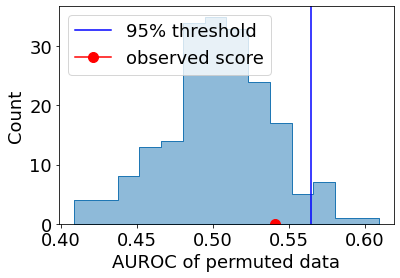

In [41]:
ax = sns.histplot(permuted_scores, element='step', alpha=0.5)
ax.set(xlabel = 'AUROC of permuted data');
lh = ax.axvline(np.percentile(permuted_scores, 95), color='b',label='95% threshold')
mh = ax.plot(observed_score, 0, marker='o', color='r', markersize=10, label='observed score')
ax.legend();

p = (sum(permuted_scores > observed_score) + 1) / (n_permutations + 1)
print('p vlaue = ', p)

In this case, there is no evidence for significant classification of expression within this ROI.

\
Just as scikit-learn has a function (`cross_val_score`) to simplify the cross-validation loop, it also has a similar function (`permutation_test_score`) to simplify the permutation process. This also allows the permutation to be run in parallel, which can be much faster! 

In [42]:
tic = time.time()

actual_score, permuted_scores, p = skl.model_selection.permutation_test_score(pipe, all_data, all_labels, groups = run_indices,
                                    scoring = 'roc_auc', cv = logo, n_permutations = n_permutations, n_jobs = -1, random_state = None)

print('Took ', time.time()-tic,' s')
print("p value = ", p)

Took  3.809922456741333  s
p value =  0.19900497512437812


This p-value should, on average, be similar to above, but will differ because of the randomness of the permutations. As the number of unique permutations increases, the p-values from different repetitions should become more similar, giving an idea of the robustness of the permutation-p-value.

\
So far we have considered a single ROI. If we want to know where in the brain a representation is strongest, we can compare multiple ROIs. Sometimes we might be interested in discrete regions that cover the brain (e.g. an atlas/parcellation), but if we want a spatially continuous output, without making assumptions about area borders, we can use a "searchlight". 

## Searchlight analysis

A searchlight is not really anything special. It's just a set of overlapping ROIs, often spherical, that cover the brain (or analysis mask of interest). Each searchlight's classification performance is typically assigned to its central voxel. The inferences one would make are very similar to a voxel-wise, mass-univariate analysis of smoothed data (see Dace's sessions). Increasing the size of the searchlight reduces the spatial specificity of the inference, while tending to increase sensitivity, in a very similar way to increasing the smoothing kernal in univariate analysis. Similarly to the matched-filter theorem for univariate analyses, the optimal searchlight size will depend on the spatial scale of the signal and the spatial scale of the noise. It is sometimes assumed that searchlights need to be spatially contiguous, because they usually are, but the definition of a searchlight is just as flexible as the definition of any ROI. 

A searchlight analysis can be set up using nilearn's `.searchlight` object. This *is* restricted to contiguous spherical searchlights. When the searchlight object is created, it needs to be given a mask specifying which voxels will be included in the searchlights. So first we'll get an analysis mask that covers the whole brain. As before, we can load a template-space mask from nilearn, and resample it to match the data: 

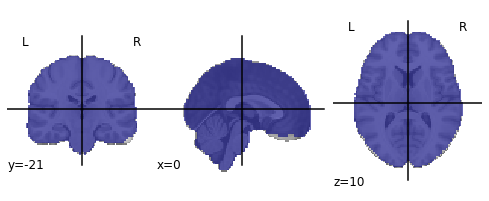

In [43]:
brain_mask = nil.datasets.load_mni152_brain_mask()
brain_mask = nil.image.resample_to_img(brain_mask, patterns_4D, interpolation='nearest')

has_data =   nil.image.math_img('(img.prod(axis=3) !=0)', img=patterns_4D); # not zero for any sample
brain_mask = nil.image.math_img('(in_mask & has_data)', in_mask=brain_mask, has_data=has_data);

display = nil.plotting.plot_roi(brain_mask,alpha=0.6);

\
We can also provide a second, optional mask that specifies where the searchlights are centred. To save some time, we'll constrain these to be in cortical grey matter of the left hemisphere. We could also load a grey-matter mask from nilearn, but here we'll use the 'Left Cerebral Cortex' region of the atlas we loaded earlier:

In [44]:
# gm_mask = nil.datasets.load_mni152_gm_mask()
# gm_mask = nil.image.resample_to_img(gm_mask, patterns_4D, interpolation='nearest')

l_cortex_id = HO_atlas['labels'].index('Left Cerebral Cortex')                                # get the ID of the Left Cerebral Cortex
gm_mask     = nil.image.math_img(f'(map == {l_cortex_id} )', map=resampled_ROI_map)           # create binary mask of this ROI
gm_mask     = nil.image.math_img('(in_mask & has_data)', in_mask=gm_mask, has_data=has_data); # restrict mask to voxels that have data

display = nil.plotting.plot_roi(nil.image.math_img('a+2*b', a=gm_mask, b=brain_mask),alpha=0.6,cmap='summer');

ValueError: 'Left Cerebral Cortex' is not in list

Now we can create the `searchlight` object. We will also specify some other optional inputs, explained in the code below:

In [ ]:
pipe = skl.pipeline.make_pipeline(LDA) # we won't do PCA, because this would fail for some searchlights (think about why)

sl = nil.decoding.SearchLight(
    mask_img = brain_mask,       # only include these voxels within searchlights
    process_mask_img = gm_mask,  # only centre searchlights on these voxels 
    radius = 5,                  # in mm
    estimator = pipe,            # a classifier or pipeline object
    n_jobs = -1,                 # how many CPUs to use (-1 means the maximum available)
    scoring = 'roc_auc',         # choice of scoring metric
    cv = logo,                   # cross-validation object
    verbose = False              # this is slow, so if running locally (1 job) set it to true to know how far it's got; when running in parallel it produces too much output, so set to false
)

\
To launch the searchlight analysis, call the `searchlight` object's `.fit` method, passing it the patterns, the labels, and optionally the groups for cross-validation.
This will take a while (probably about 5 minutes on the virtual machine, with 4 cores)...

In [ ]:
all_data = nil.image.concat_imgs(brain_data_per_run) # concatenate 4D nifti files from each run (along the 4th dimension)

print('Shape of 4D nifti data:', all_data.shape)
print('Shape of mask:', sl.mask_img.shape)
print('Shape of process_mask:', sl.process_mask_img.shape)

print('Running searchlight...')
tic = time.time()
sl.fit(all_data,all_labels, groups=run_indices)
print('Took ', time.time()-tic,' s')

\
The output (here, mean AUROC) per voxel is stored in the  `scores_` property of the searchlight object (as a 3D numpy array). If we convert this to a nifti volume, we can plot it using nilearn. We'll also subtract chance (here, 0.5), so that positive and negative values will indicate above- and below-chance decoding performance:

In [ ]:
print('Shape of output numpy array: ', sl.scores_.shape)
scores = sl.scores_ - 0.5 # subtract chance
score_img = nil.image.new_img_like(brain_mask, sl.scores_ - 0.5); # save in samme format as the brain_mask
score_img = nil.image.math_img('score_img * processing_mask', score_img=score_img,processing_mask=gm_mask); # set voxels outside the processing mask to zero
nil.plotting.plot_stat_map(score_img, threshold=0, cmap='bwr', cut_coords=(-18, -31, -16));

In [ ]:
nil.plotting.view_img_on_surf(score_img, threshold=0,cmap='bwr',symmetric_cmap=True)